In [361]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [362]:
file = open("out.pickle", "rb")
test = pickle.load(file)

In [363]:
threshold = 0.7

In [364]:
keep = []
for box in test:
    if box["score"] >= threshold:
        box["x1"] = box["bbox"][0]
        box["y1"] = box["bbox"][1]
        box["x2"] = box["bbox"][2]
        box["y2"] = box["bbox"][3]
        del box["category_id"]
        del box["bbox"]
        keep.append(box)

In [365]:
df = pd.DataFrame(keep)

In [366]:
df[df["image_id"] == "Datasets/img/" + "00c02d63e6f972a84cde9501027f80de854aeb9d.jpg"]

,category,image_id,score,x1,x2,y1,y2
663,0,Datasets/img/00c02d63e6f972a84cde9501027f80de8...,0.9983,3.8267,179.6475,654.2731,925.9178
664,0,Datasets/img/00c02d63e6f972a84cde9501027f80de8...,0.9965,407.4856,599.1133,672.2417,921.3408
665,8,Datasets/img/00c02d63e6f972a84cde9501027f80de8...,0.9950,1523.6443,1670.6987,576.6973,802.2020
666,9,Datasets/img/00c02d63e6f972a84cde9501027f80de8...,0.9904,817.1712,966.5369,640.4652,904.4434
667,5,Datasets/img/00c02d63e6f972a84cde9501027f80de8...,0.9764,1175.8069,1344.2170,637.8030,904.8793
668,7,Datasets/img/00c02d63e6f972a84cde9501027f80de8...,0.9743,1531.4900,1680.1084,825.3096,985.1182


In [367]:
def get_number(df):
    df = df.sort_values(by=["x1"])
    score = ""
    width = 0
    last_x = -1000
    for index, row in df.iterrows():
        width = row["x2"] - row["x1"]
        if row["category"] != ".":
            if row["x1"] - last_x >= width / 2:
                score += str(row["category"])
        else:
            score += str(row["category"])
        last_x = row["x1"]
        
    k = 0
    # print(score)
    while k < len(score) - 1 :
        try:
            if score[k] == "." and score[k + 1] == ".":
                score = score[:k] + score[k + 1:]
                k -= 1
        except Exception as e:
            print(score, k)
            raise e 
        k += 1
    return float(score)

scores = df.groupby("image_id").apply(get_number)
scores = scores.reset_index()
scores.columns = ["image", "used_liters_predict"]
scores.head()

,image,used_liters_predict
0,Datasets/img/00201faada9ddb1eb44736b913ec0af23...,463.0
1,Datasets/img/0021b9d54ed9b15b961c3c946ec04d22f...,18022.0
2,Datasets/img/002cb910bea6ad00376f54f511e28b7fd...,126.0
3,Datasets/img/003aba708b58d1cdc4322b5f203096d65...,6.0
4,Datasets/img/003f850dd53366ca94bf48a6d47025d2e...,50.0


In [368]:
path_useless = "Datasets/img/"
scores["image"] = scores.image.str[len(path_useless):]
scores.head()

,image,used_liters_predict
0,00201faada9ddb1eb44736b913ec0af2334a8753.jpg,463.0
1,0021b9d54ed9b15b961c3c946ec04d22fa4475d7.jpg,18022.0
2,002cb910bea6ad00376f54f511e28b7fd50ce22b.jpg,126.0
3,003aba708b58d1cdc4322b5f203096d65e3e51c4.jpg,6.0
4,003f850dd53366ca94bf48a6d47025d2e8241723.jpg,50.0


In [369]:
hq_dig = pd.read_csv("Datasets/HQ_quality.csv", sep=";", index_col=0)
hq_ana = pd.read_csv("Datasets/HQ_analog.csv", sep=";", index_col=0)
lq_dig = pd.read_csv("Datasets/LQ_digital.csv", sep=";", index_col=0)
lq_ana = pd.read_csv("Datasets/LQ_analog.csv", sep=";", index_col=0)
mq_dig = pd.read_csv("Datasets/MQ_digital.csv", sep=";", index_col=0)

hq_dig["q"] = "HD"
hq_ana["q"] = "HA"
lq_dig["q"] = "LD"
lq_ana["q"] = "LA"
mq_dig["q"] = "MD"
ground_truth = pd.concat((hq_dig, hq_ana, lq_dig, lq_ana, mq_dig))

In [370]:
ground_truth.head()

,used_liter,image,q
0,33,e104664ba1792dde641d87cd5d95f1df06786140.jpg,HD
1,29,48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg,HD
2,230,9e111802446b62b86aeffe911415ad28227caba7.jpg,HD
3,43,f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg,HD
4,51,62e96bf40409b3b6fd74065ab0bf3ec44f9d0a61.jpg,HD


In [371]:
final = scores.merge(ground_truth, on="image")

In [372]:
final.head()

,image,used_liters_predict,used_liter,q
0,00201faada9ddb1eb44736b913ec0af2334a8753.jpg,463.0,463,LA
1,0021b9d54ed9b15b961c3c946ec04d22fa4475d7.jpg,18022.0,18022,LA
2,002cb910bea6ad00376f54f511e28b7fd50ce22b.jpg,126.0,126,LA
3,003aba708b58d1cdc4322b5f203096d65e3e51c4.jpg,6.0,64,LA
4,003f850dd53366ca94bf48a6d47025d2e8241723.jpg,50.0,50,LD


In [373]:
final["correct"] = np.abs(final["used_liters_predict"] - final["used_liter"])

In [395]:
final["bool"] = final["correct"] <= 1

In [396]:
gb = final.groupby("q")
total = gb["bool"].count()
total

q
HA    34
HD    29
LA    66
LD    45
MD    52
Name: bool, dtype: int64

In [397]:
gb2 = final[final["bool"] == True].groupby("q")
total2 = gb2["bool"].count()
total2

q
HA    34
HD    26
LA    55
LD    45
MD    49
Name: bool, dtype: int64

In [398]:
total2/total

q
HA    1.000000
HD    0.896552
LA    0.833333
LD    1.000000
MD    0.942308
Name: bool, dtype: float64

In [399]:
test = total2/total

In [400]:
test = test.reset_index()

In [401]:
test.columns=["Quality", "Accuracy"]

In [402]:
test

,Quality,Accuracy
0,HA,1.000000
1,HD,0.896552
2,LA,0.833333
3,LD,1.000000
4,MD,0.942308


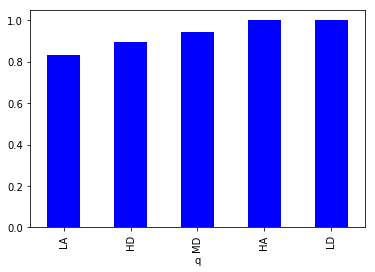

In [403]:
(total2/total).sort_values().plot.bar(color='b')

In [404]:
final[final["bool"] == True].count() / len(final.index)

image                  0.924779
used_liters_predict    0.924779
used_liter             0.924779
q                      0.924779
correct                0.924779
bool                   0.924779
dtype: float64

In [405]:
final[final["bool"] == False]

,image,used_liters_predict,used_liter,q,correct,bool
3,003aba708b58d1cdc4322b5f203096d65e3e51c4.jpg,6.0,64,LA,58.0,False
11,01230cb83c6ca74e7c54813dec474cef9114ab93.jpg,86.0,88,LA,2.0,False
22,01edaa6408cdcef6a4159c04fd120c2113fb839e.jpg,1877.0,188,LA,1689.0,False
23,01ef00a01ef527d6b6f5c140f607738ed3774a69.jpg,141.0,213,LA,72.0,False
24,01fea40101d11d0f31dbaa13bfcd9c64e54cec2d.jpg,85.0,286,LA,201.0,False
25,020340015a4ed64ee77778fcc03a4f5328f0b38c.jpg,52.0,523,LA,471.0,False
43,03b1e01ccce98f8b9646afa8b75ce81e90188a72.jpg,27.0,273,LA,246.0,False
49,0439c7e7bc2d6c0a85ca45111f15f0a859468be0.jpg,1207.0,208,MD,999.0,False
60,05417700b76f523cc74f17d86d778a5273d99869.jpg,157.0,57,MD,100.0,False
91,0b21b4461483bedb04c0aa7032af8fd6deb6822c.jpg,20.0,229,LA,209.0,False
